# Environment setup
Follow the tutorial about how to utilize Google Colab but **don't install PyTorch** as mentioned in the blog post.

Turkish:
https://medium.com/deep-learning-turkiye/google-colab-ile-%C3%BCcretsiz-gpu-kullan%C4%B1m%C4%B1-30fdb7dd822e

English:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d



In [1]:
# This part probably will be enough for utilizing Drive in Colab
# but examine links above if you encounter with problems.
#from google.colab import drive
#drive.mount('/content/drive/', force_remount=True)


# Now, you will work on the problem of Insect Pest Recognition using IP102 data, where you have 8 classes

After having mounted the Jupyter Notebook to Google Drive, navigate the following address:

https://drive.google.com/open?id=1qrl7JtGtOEtcYAbD5wX2D538VQNmeC8C

Add this folder entirely to your Google Drive. If you have done it correctly, then you should be able to see IP102 in your drive.

You can examine info about the dataset in this github repo: 
https://github.com/xpwu95/IP102



### Don't forget to choose the right runtime from the menu above. (GPU should be selected)

In [2]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right. 
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Sun Nov 24 07:28:20 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

You are free to utilize Pytorch methods in this part of the Homework. 
You will be using pretained models ResNet50, DenseNet-121 and your own model.

Below, you will find required modules loaded. 

In [3]:
# All libraries are already presented in Colab Servers, we don't need to install anything with pip
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import normalize, resize, to_tensor
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## DataLoader and Dataset
Here, we provide you an fully functional Dataset but to ensure that you understood how it works. You can change some parts if you want to train with subset of dataset at first.

In [4]:
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

### The code below is to make you be able to load by using Pillow.
class IPLoader(Dataset):
    def __init__(self, path, mode='train'):
        self.class_num = 8
        self.images_splitted = '{}/Images_Splitted/'.format(path)
        self.file_path = '{}/{}.txt'.format(path,mode)
        self.mode = mode
        self.images = []
        with open(self.file_path, 'r') as f:
             self.images = f.readlines()
        print(len(self.images))
        
    # There are 102 classes in original dataset but we will use 8 super classes in order to classify easily.
    def get_super_label(self,num):
        if num <= 14:
          return 0
        elif num <= 27:
          return 1
        elif num <= 36:
          return 2
        elif num <= 44:
          return 3
        elif num <= 57:
          return 4
        elif num <= 73:
          return 5
        elif num <= 92:
          return 6
        else:
          return 7 
            
    # This method normalizes each image individually. You may want to normalize it by using ImageNet statistics
    # If you would like to fine tune so feel free to do changes
    def preprocess(self, x):
        x = resize(x, (224, 224)) # Resnet, Densenet
        #x = resize(x, (256, 256)) # You can use different input size for your model such as 256x256
        x = to_tensor(x)
        #normalize(x,  mean=[el.mean() for el in x] ,std=[el.std() for el in x]) # Channel Standard Normalization
        x = normalize(x,mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Imagenet Normalization
        return x
    
    # This method basically loads image from the file system
    def load(self, path):
        img = Image.open(path)
        img.load()
        return img

    # This method gets one item in order to construct batches
    def __getitem__(self, ix):
        image = self.images[ix]
        line = image.split()
        path = '{}{}_{}/'.format(self.images_splitted,self.mode,ix // 1000)
        
        #Get its relative path and label
        data_path = '{}{}'.format(path,line[0])
        label = self.get_super_label(int(line[1]))
        
        # Load image
        data = self.load(data_path)

        #There are some files with 4 channels we take only RGB channels of them
        if not np.array(data).shape[2] == 3:
            data = np.array(data)
            data = data[:,:,:3]
            data = Image.fromarray(data)
        
        # Do Prepocessing on data
        data_normalized = self.preprocess(data)
        
        # Then return the data and its label.
        return data_normalized, label
        
        
    # This method gives number of samples in dataset
    def __len__(self):
        return len(self.images)

# Load separately ResNet and DenseNet models

You can find tutorials on how to load those models at pytorch.org . Don't forget to use pretrained=True if you wish to do finetuning.

In [5]:
# Load models here
import torchvision
# We use 8 super class to classify
num_classes = 8 
resnet50 = torchvision.models.resnet50(pretrained=True)
for param in resnet50.parameters():
    param.requires_grad = False
resnet50.fc = nn.Linear(in_features=2048, out_features=num_classes)

for name, param in resnet50.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

densenet = torchvision.models.densenet121(pretrained=True)
# Freeze all layers except last 3 layers and classification layer
for param in densenet.parameters():
    param.requires_grad = False
densenet.classifier = nn.Linear(in_features=1024, out_features=num_classes)

for name, param in densenet.named_parameters():
    if "denselayer16" in name or "denselayer15" in name or "denselayer14" in name:
        param.requires_grad = True


# Additionally, build your own model which is different from the other models, train on the IP dataset
**Report your loss curves at the end of the notebook**

In [6]:
# Model is consist of 10 convolution layer with batchnorm and ReLU activation
# Model is created by using same logic with the VGG networks that use 3x3 convolutions
# Number of channels throughout the network are below: 
# [3 -> 64 -> 64 -> 128 -> 128 -> 256 -> 256 -> 512 -> 512 -> 512 -> Linear classification ]
# After two convolutional layers, maxpool is used with stride 2 and kernel size 2
# Maxpooling layers are effective to decrease the number of parameters.
# Note that this model needs high amount of training from scratch (probably 10 hours) for good accuracies.
# Training on the Google Colab takes so much time to effectively train the network.
class YourModel(nn.Module):
    def __init__(self):
        # TO DO: Your neural network design
        super(YourModel, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.extractor = nn.Sequential(nn.Conv2d(3,64, kernel_size=3, padding=1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(64,64, kernel_size=3, padding=1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(kernel_size=2, stride=2),
                                nn.Conv2d(64,128, kernel_size=3, padding=1),
                                nn.BatchNorm2d(128),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(128,128, kernel_size=3, padding=1),
                                nn.BatchNorm2d(128),
                                nn.ReLU(inplace=True),                                        
                                nn.MaxPool2d(kernel_size=2, stride=2),
                                nn.Conv2d(128,256, kernel_size=3, padding=1),
                                nn.BatchNorm2d(256),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(256,256, kernel_size=3, padding=1),
                                nn.BatchNorm2d(256),
                                nn.ReLU(inplace=True),                                        
                                nn.MaxPool2d(kernel_size=2, stride=2),    
                                nn.Conv2d(256,512, kernel_size=3, padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(512,512, kernel_size=3, padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace=True),                                        
                                nn.MaxPool2d(kernel_size=2, stride=2),  
                                nn.Conv2d(512,512, kernel_size=3, padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(512,512, kernel_size=3, padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace=True),                                        
                                nn.MaxPool2d(kernel_size=2, stride=2)
                                )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
            nn.Softmax()
        )
        
    def forward(self, x):
        # TO DO: Your neural network design
        x = self.extractor(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out = self.classifier(x)
        return out

In [7]:
###  Here are some training parameters
batch_size = 32
learning_rate = 3e-2
regularization_rate = 0
n_epochs = 10
use_gpu = True
test_every = 1
test_every_iteration = 100
###

In [8]:
dataset_train = IPLoader(path='drive/My Drive/IP102', mode='train')
dataset_test = IPLoader(path='drive/My Drive/IP102', mode='test')
dataset_val = IPLoader(path='drive/My Drive/IP102', mode='val')

train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, num_workers=4, shuffle=False)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, num_workers=4, shuffle=False)

45095
10000
7508


** Finetune/Train the loaded/designed model here:**

Don't forget to include appropriate regularizations.
Choose appropriate set of hyperparameters such as Learning Rate etc.

You may insert new cells.

In [9]:
def train(model, criteria, optimizer):
    # It modifies the behaviour of modules like BatchNorm and Dropout for training purposes
    model.train()
    if use_gpu:
        model.cuda()
        criteria.cuda()

    # Some example diagnostics.

    # Loss for every iteration
    losses_iter_train = []
    # Loss for epoch (averaging the iteration-wise loss)
    losses_epoch_train = []
    accuracy_iter_train = []
    accuracy_epoch_train = []

    losses_iter_val = []
    losses_epoch_val = []
    accuracy_iter_val = []
    accuracy_epoch_val = []

    # Write the training loop
    for epoch in range(n_epochs):
        for ix, data in enumerate(train_loader):
            optimizer.zero_grad()
            img, label = data
            if use_gpu:
                img = img.cuda()
                label = label.cuda()
            
            # Give images to model
            output = model(img)
            # Calculate loss 
            loss = criteria(output,label)
            losses_iter_train.append(loss.item())
            # Check accuracy of the iteration
            predicts = torch.argmax(output,dim=1)
            true_p = torch.sum(predicts == label).cpu().numpy()
            accuracy_iter_train.append(true_p*100/predicts.shape[0])
            # Back propagate the model
            loss.backward()
            optimizer.step()
            if ix % test_every_iteration == 0:
                print('Iteration [%1d /%1d] Training Loss: %.3f Training Accuracy: %.3f' % (ix+1, len(train_loader), losses_iter_train[-1],accuracy_iter_train[-1]))
        if epoch % test_every == 0:
            with torch.no_grad():
                # Measure the performance in validation set.
                model.eval()
                for iy, evaldata in enumerate(val_loader):
                    # Give images to model
                    img, label = evaldata
                    if use_gpu:
                        img = img.cuda()
                        label = label.cuda()                
                    output = model(img)
                    # Calculate loss 
                    loss = criteria(output,label)
                    losses_iter_val.append(loss.item())
                    # Check accuracy of the iteration
                    predicts = torch.argmax(output,dim=1)
                    true_p = torch.sum(predicts == label).cpu().numpy()
                    accuracy_iter_val.append(true_p*100/predicts.shape[0]) 
        # Calculate epoch metrics     
        losses_epoch_val.append(np.mean(losses_iter_val[-len(val_loader):]))
        accuracy_epoch_val.append(np.mean(accuracy_iter_val[-len(val_loader):]))
        # Calculate epoch metrics
        losses_epoch_train.append(np.mean(losses_iter_train[-len(train_loader):]))
        accuracy_epoch_train.append(np.mean(accuracy_iter_train[-len(train_loader):]))
        print('Epoch [%1d /%1d] Training Loss: %.3f Training Accuracy: %.3f' % (epoch + 1, n_epochs, losses_epoch_train[-1], accuracy_epoch_train[-1]))
        if epoch%test_every == 0: print('Epoch [%1d /%1d] Validation Loss: %.3f Validation Accuracy: %.3f' % (epoch + 1, n_epochs, losses_epoch_val[-1], accuracy_epoch_val[-1]))
        model.train()
    metric_dict = {}
    metric_dict["losses_iter_train"]=losses_iter_train
    metric_dict["losses_epoch_train"]=losses_epoch_train
    metric_dict["accuracy_iter_train"]=accuracy_iter_train
    metric_dict["accuracy_epoch_train"]=accuracy_epoch_train
    metric_dict["losses_iter_val"]=losses_iter_val
    metric_dict["losses_epoch_val"]=losses_epoch_val
    metric_dict["accuracy_iter_val"]=accuracy_iter_val
    metric_dict["accuracy_epoch_val"]=accuracy_epoch_val
    return  metric_dict


### Measure the performance against test set
Complete the code

In [10]:
def test(model):
    # It modifies the behaviour of modules like BatchNorm and Dropout for test purposes
    # Dropout no longer works when .eval() is called.
    # BatchNorm uses the learned parameters
    true_false_predicts = []
    model.eval()

    with torch.no_grad():
        for data in test_loader:
            img, label = data
            if use_gpu:
                img = img.cuda()
                label = label.cuda()
            
            output = model(img)
            # Calculate loss 
            predicts = torch.argmax(output,dim=1)
            true_p = torch.sum(predicts == label).cpu().numpy()
            true_false_predicts.append((true_p,len(predicts)-true_p))

        # Calculate accuracy for all dataset
        total_true = 0
        total_false = 0
        for t,f in true_false_predicts:
            total_true += t
            total_false+= f

        accuracy = total_true*100/(total_true+total_false)
        print("Test Accuracy: {}".format(accuracy))
        return accuracy

**Run diagnostics for each model (ResNet and DenseNet). Avoid overfitting and underfitting as much as possible. Try to get highest validation and test accuracy(at least 60%)**

**Plot the training and validation losses versus number of iterations or epochs for ResNet50 on the same plot and obtain test accuracy**

In [11]:
model = resnet50
# Only train last few layers with appropriate regularization parameter
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate,weight_decay=1e-5)
criteria = nn.CrossEntropyLoss()

resnet_metrics = train(model,criteria,optimizer)
resnet_accuracy = test(model)

Iteration [1 /1410] Training Loss: 2.122 Training Accuracy: 15.625
Iteration [101 /1410] Training Loss: 1.771 Training Accuracy: 37.500
Iteration [201 /1410] Training Loss: 1.180 Training Accuracy: 62.500
Iteration [301 /1410] Training Loss: 1.214 Training Accuracy: 56.250
Iteration [401 /1410] Training Loss: 0.958 Training Accuracy: 65.625
Iteration [501 /1410] Training Loss: 1.388 Training Accuracy: 50.000
Iteration [601 /1410] Training Loss: 1.007 Training Accuracy: 71.875
Iteration [701 /1410] Training Loss: 1.046 Training Accuracy: 59.375
Iteration [801 /1410] Training Loss: 0.985 Training Accuracy: 68.750
Iteration [901 /1410] Training Loss: 1.187 Training Accuracy: 65.625
Iteration [1001 /1410] Training Loss: 1.037 Training Accuracy: 62.500
Iteration [1101 /1410] Training Loss: 1.242 Training Accuracy: 53.125
Iteration [1201 /1410] Training Loss: 0.921 Training Accuracy: 62.500
Iteration [1301 /1410] Training Loss: 1.147 Training Accuracy: 56.250
Iteration [1401 /1410] Training 

Resnet Test Accuracy = 63.49 %


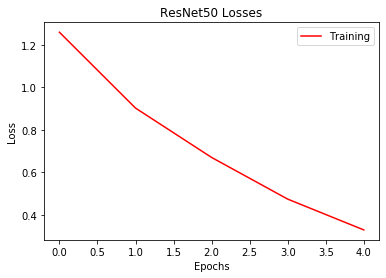

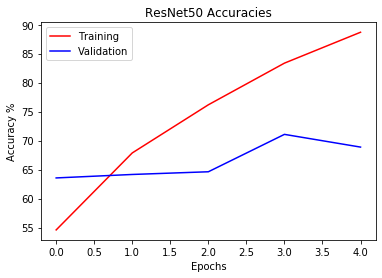

In [12]:
print("Resnet Test Accuracy =",resnet_accuracy,"%")
fig = plt.figure()
axes = plt.subplot(111)
axes.plot(resnet_metrics["losses_epoch_train"],color="r",linestyle="-" ,label='Training')
axes.set_xlabel("Epochs")
axes.set_ylabel("Loss")
axes.legend()
axes.set_title("ResNet50 Losses")
plt.show()

fig = plt.figure()
axes = plt.subplot(111)
axes.plot(resnet_metrics["accuracy_epoch_train"],color="r",linestyle="-" ,label='Training')
axes.plot(resnet_metrics["accuracy_epoch_val"],color="b",linestyle="-" ,label='Validation')
axes.set_xlabel("Epochs")
axes.set_ylabel("Accuracy %")
axes.legend()
axes.set_title("ResNet50 Accuracies")
plt.show()

**Plot the training and validation losses versus number of iterations or epochs for DenseNet121 on the same plot and obtain test accuracy**

In [13]:
model = densenet
# Only train last few layers with appropriate regularization parameter
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate,weight_decay=1e-5)
criteria = nn.CrossEntropyLoss()

densenet_metrics = train(model,criteria,optimizer)
densenet_accuracy = test(model)

Iteration [1 /1410] Training Loss: 2.163 Training Accuracy: 6.250
Iteration [101 /1410] Training Loss: 1.558 Training Accuracy: 43.750
Iteration [201 /1410] Training Loss: 1.516 Training Accuracy: 43.750
Iteration [301 /1410] Training Loss: 1.330 Training Accuracy: 50.000
Iteration [401 /1410] Training Loss: 1.331 Training Accuracy: 56.250
Iteration [501 /1410] Training Loss: 1.459 Training Accuracy: 40.625
Iteration [601 /1410] Training Loss: 1.509 Training Accuracy: 46.875
Iteration [701 /1410] Training Loss: 1.160 Training Accuracy: 68.750
Iteration [801 /1410] Training Loss: 1.308 Training Accuracy: 50.000
Iteration [901 /1410] Training Loss: 1.351 Training Accuracy: 46.875
Iteration [1001 /1410] Training Loss: 1.234 Training Accuracy: 68.750
Iteration [1101 /1410] Training Loss: 1.197 Training Accuracy: 56.250
Iteration [1201 /1410] Training Loss: 1.505 Training Accuracy: 56.250
Iteration [1301 /1410] Training Loss: 0.817 Training Accuracy: 75.000
Iteration [1401 /1410] Training L

DenseNet121 Test Accuracy = 64.18 %


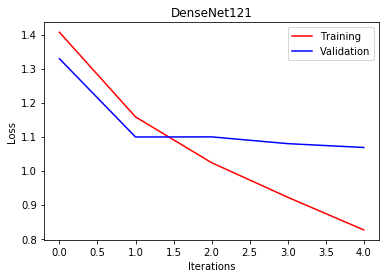

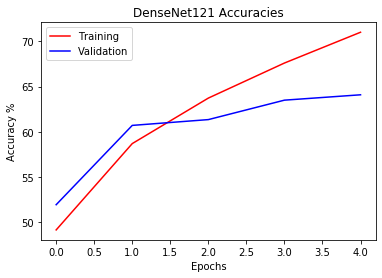

In [14]:
print("DenseNet121 Test Accuracy =",densenet_accuracy,"%")
fig = plt.figure()
axes = plt.subplot(111)
axes.plot(densenet_metrics["losses_epoch_train"],color="r",linestyle="-" ,label='Training')
axes.plot(densenet_metrics["losses_epoch_val"],color="b",linestyle="-" ,label='Validation')
axes.set_xlabel("Iterations")
axes.set_ylabel("Loss")
axes.legend()
axes.set_title("DenseNet121")
plt.show()

fig = plt.figure()
axes = plt.subplot(111)
axes.plot(densenet_metrics["accuracy_epoch_train"],color="r",linestyle="-" ,label='Training')
axes.plot(densenet_metrics["accuracy_epoch_val"],color="b",linestyle="-" ,label='Validation')
axes.set_xlabel("Epochs")
axes.set_ylabel("Accuracy %")
axes.legend()
axes.set_title("DenseNet121 Accuracies")
plt.show()

### BatchNorm Comparison

**Create two models one with batchnorm layers and one without batchnorm layers**


In [15]:
model = YourModel()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate,weight_decay=1e-2)
criteria = nn.CrossEntropyLoss()

batchnorm_model_metrics = train(model,criteria,optimizer)
batchnorm_model_accuracy = test(model)

/storage/alperen/miniconda3/envs/PyTorch/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Iteration [1 /1410] Training Loss: 2.084 Training Accuracy: 9.375
Iteration [101 /1410] Training Loss: 2.010 Training Accuracy: 28.125
Iteration [201 /1410] Training Loss: 1.983 Training Accuracy: 31.250
Iteration [301 /1410] Training Loss: 1.907 Training Accuracy: 37.500
Iteration [401 /1410] Training Loss: 2.113 Training Accuracy: 9.375
Iteration [501 /1410] Training Loss: 1.960 Training Accuracy: 34.375
Iteration [601 /1410] Training Loss: 1.965 Training Accuracy: 28.125
Iteration [701 /1410] Training Loss: 1.801 Training Accuracy: 46.875
Iteration [801 /1410] Training Loss: 1.866 Training Accuracy: 37.500
Iteration [901 /1410] Training Loss: 1.910 Training Accuracy: 31.250
Iteration [1001 /1410] Training Loss: 1.976 Training Accuracy: 34.375
Iteration [1101 /1410] Training Loss: 1.942 Training Accuracy: 37.500
Iteration [1201 /1410] Training Loss: 2.024 Training Accuracy: 21.875
Iteration [1301 /1410] Training Loss: 1.830 Training Accuracy: 43.750
Iteration [1401 /1410] Training Lo

Iteration [101 /1410] Training Loss: 2.029 Training Accuracy: 25.000
Iteration [201 /1410] Training Loss: 1.896 Training Accuracy: 40.625
Iteration [301 /1410] Training Loss: 1.891 Training Accuracy: 37.500
Iteration [401 /1410] Training Loss: 1.990 Training Accuracy: 28.125
Iteration [501 /1410] Training Loss: 1.956 Training Accuracy: 31.250
Iteration [601 /1410] Training Loss: 1.961 Training Accuracy: 25.000
Iteration [701 /1410] Training Loss: 1.924 Training Accuracy: 31.250
Iteration [801 /1410] Training Loss: 1.918 Training Accuracy: 34.375
Iteration [901 /1410] Training Loss: 1.933 Training Accuracy: 34.375
Iteration [1001 /1410] Training Loss: 1.839 Training Accuracy: 43.750
Iteration [1101 /1410] Training Loss: 1.885 Training Accuracy: 37.500
Iteration [1201 /1410] Training Loss: 2.051 Training Accuracy: 21.875
Iteration [1301 /1410] Training Loss: 1.800 Training Accuracy: 46.875
Iteration [1401 /1410] Training Loss: 1.973 Training Accuracy: 28.125
Epoch [8 /10] Training Loss: 

In [16]:
# Model without batchnorm layers
class NoBatchNormModel(nn.Module):
    def __init__(self):
        # TO DO: Your neural network design
        super(NoBatchNormModel, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.extractor = nn.Sequential(nn.Conv2d(3,64, kernel_size=3, padding=1),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(64,64, kernel_size=3, padding=1),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(kernel_size=2, stride=2),
                                nn.Conv2d(64,128, kernel_size=3, padding=1),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(128,128, kernel_size=3, padding=1),
                                nn.ReLU(inplace=True),                                        
                                nn.MaxPool2d(kernel_size=2, stride=2),
                                nn.Conv2d(128,256, kernel_size=3, padding=1),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(256,256, kernel_size=3, padding=1),
                                nn.ReLU(inplace=True),                                        
                                nn.MaxPool2d(kernel_size=2, stride=2),    
                                nn.Conv2d(256,512, kernel_size=3, padding=1),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(512,512, kernel_size=3, padding=1),
                                nn.ReLU(inplace=True),                                        
                                nn.MaxPool2d(kernel_size=2, stride=2),  
                                nn.Conv2d(512,512, kernel_size=3, padding=1),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(512,512, kernel_size=3, padding=1),
                                nn.ReLU(inplace=True),                                        
                                nn.MaxPool2d(kernel_size=2, stride=2)
                                )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
            nn.Softmax()
        )
        
    def forward(self, x):
        # TO DO: Your neural network design
        x = self.extractor(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out = self.classifier(x)
        return out

In [17]:
model = NoBatchNormModel()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate,weight_decay=1e-2)
criteria = nn.CrossEntropyLoss()

no_batchnorm_model_metrics = train(model,criteria,optimizer)
no_batchnorm_model_accuracy = test(model)

Iteration [1 /1410] Training Loss: 2.080 Training Accuracy: 18.750
Iteration [101 /1410] Training Loss: 2.078 Training Accuracy: 31.250
Iteration [201 /1410] Training Loss: 2.078 Training Accuracy: 21.875
Iteration [301 /1410] Training Loss: 2.073 Training Accuracy: 28.125
Iteration [401 /1410] Training Loss: 2.076 Training Accuracy: 15.625
Iteration [501 /1410] Training Loss: 2.072 Training Accuracy: 21.875
Iteration [601 /1410] Training Loss: 2.069 Training Accuracy: 25.000
Iteration [701 /1410] Training Loss: 2.070 Training Accuracy: 15.625
Iteration [801 /1410] Training Loss: 2.070 Training Accuracy: 25.000
Iteration [901 /1410] Training Loss: 2.067 Training Accuracy: 25.000
Iteration [1001 /1410] Training Loss: 2.060 Training Accuracy: 18.750
Iteration [1101 /1410] Training Loss: 2.075 Training Accuracy: 15.625
Iteration [1201 /1410] Training Loss: 2.056 Training Accuracy: 25.000
Iteration [1301 /1410] Training Loss: 2.068 Training Accuracy: 15.625
Iteration [1401 /1410] Training 

Iteration [101 /1410] Training Loss: 2.015 Training Accuracy: 25.000
Iteration [201 /1410] Training Loss: 1.945 Training Accuracy: 34.375
Iteration [301 /1410] Training Loss: 2.043 Training Accuracy: 18.750
Iteration [401 /1410] Training Loss: 1.987 Training Accuracy: 31.250
Iteration [501 /1410] Training Loss: 2.086 Training Accuracy: 9.375
Iteration [601 /1410] Training Loss: 2.036 Training Accuracy: 18.750
Iteration [701 /1410] Training Loss: 2.029 Training Accuracy: 15.625
Iteration [801 /1410] Training Loss: 1.994 Training Accuracy: 28.125
Iteration [901 /1410] Training Loss: 2.064 Training Accuracy: 15.625
Iteration [1001 /1410] Training Loss: 2.080 Training Accuracy: 12.500
Iteration [1101 /1410] Training Loss: 2.113 Training Accuracy: 6.250
Iteration [1201 /1410] Training Loss: 2.020 Training Accuracy: 31.250
Iteration [1301 /1410] Training Loss: 2.030 Training Accuracy: 18.750
Iteration [1401 /1410] Training Loss: 2.040 Training Accuracy: 28.125
Epoch [8 /10] Training Loss: 2.

**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies**

Test accuracy of model with BatchNorm: 32.2
Test accuracy of model without BatchNorm: 23.64


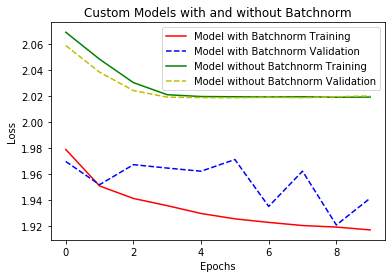

In [18]:
# Compare test accuracies
print("Test accuracy of model with BatchNorm: {}".format(batchnorm_model_accuracy))
print("Test accuracy of model without BatchNorm: {}".format(no_batchnorm_model_accuracy))

fig = plt.figure()
axes = plt.subplot(111)
axes.plot(batchnorm_model_metrics["losses_epoch_train"],color="r",linestyle="-" ,label='Model with Batchnorm Training')
axes.plot(batchnorm_model_metrics["losses_epoch_val"],color="b",linestyle="--" ,label='Model with Batchnorm Validation')
axes.plot(no_batchnorm_model_metrics["losses_epoch_train"],color="g",linestyle="-" ,label='Model without Batchnorm Training')
axes.plot(no_batchnorm_model_metrics["losses_epoch_val"],color="y",linestyle="--" ,label='Model without Batchnorm Validation')
axes.set_xlabel("Epochs")
axes.set_ylabel("Loss")
axes.legend()
axes.set_title("Custom Models with and without Batchnorm")
plt.show()

As we can see model with BatchNorm performs better. So batchnorm should be included in the final model.


### Dropout Comparison

**Create two models one with dropout layers and one without dropout layers**


In [19]:
# My own model contains dropout layers therefore i will just use
# the results of the batchnorm_model for the model with dropout
dropout_model_metrics = batchnorm_model_metrics 
dropout_model_accuracy = batchnorm_model_accuracy
# Also for the sake of fast training, epoch numbers reduced to 6
n_epochs = 6

In [20]:
# Model without dropout
class NoDropoutModel(nn.Module):
    def __init__(self):
        # TO DO: Your neural network design
        super(NoDropoutModel, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.extractor = nn.Sequential(nn.Conv2d(3,64, kernel_size=3, padding=1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(64,64, kernel_size=3, padding=1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(kernel_size=2, stride=2),
                                nn.Conv2d(64,128, kernel_size=3, padding=1),
                                nn.BatchNorm2d(128),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(128,128, kernel_size=3, padding=1),
                                nn.BatchNorm2d(128),
                                nn.ReLU(inplace=True),                                        
                                nn.MaxPool2d(kernel_size=2, stride=2),
                                nn.Conv2d(128,256, kernel_size=3, padding=1),
                                nn.BatchNorm2d(256),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(256,256, kernel_size=3, padding=1),
                                nn.BatchNorm2d(256),
                                nn.ReLU(inplace=True),                                        
                                nn.MaxPool2d(kernel_size=2, stride=2),    
                                nn.Conv2d(256,512, kernel_size=3, padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(512,512, kernel_size=3, padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace=True),                                        
                                nn.MaxPool2d(kernel_size=2, stride=2),  
                                nn.Conv2d(512,512, kernel_size=3, padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(512,512, kernel_size=3, padding=1),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace=True),                                        
                                nn.MaxPool2d(kernel_size=2, stride=2)
                                )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_classes),
            nn.Softmax()
        )
        
    def forward(self, x):
        # TO DO: Your neural network design
        x = self.extractor(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out = self.classifier(x)
        return out

In [21]:
model = NoDropoutModel()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate,weight_decay=1e-2)
criteria = nn.CrossEntropyLoss()

no_dropout_model_metrics = train(model,criteria,optimizer)
no_dropout_model_accuracy = test(model)

Iteration [1 /1410] Training Loss: 2.074 Training Accuracy: 25.000
Iteration [101 /1410] Training Loss: 1.993 Training Accuracy: 25.000
Iteration [201 /1410] Training Loss: 1.985 Training Accuracy: 28.125
Iteration [301 /1410] Training Loss: 1.954 Training Accuracy: 31.250
Iteration [401 /1410] Training Loss: 1.992 Training Accuracy: 21.875
Iteration [501 /1410] Training Loss: 1.802 Training Accuracy: 46.875
Iteration [601 /1410] Training Loss: 2.011 Training Accuracy: 21.875
Iteration [701 /1410] Training Loss: 1.959 Training Accuracy: 25.000
Iteration [801 /1410] Training Loss: 1.997 Training Accuracy: 28.125
Iteration [901 /1410] Training Loss: 1.929 Training Accuracy: 34.375
Iteration [1001 /1410] Training Loss: 1.959 Training Accuracy: 37.500
Iteration [1101 /1410] Training Loss: 1.952 Training Accuracy: 34.375
Iteration [1201 /1410] Training Loss: 1.935 Training Accuracy: 37.500
Iteration [1301 /1410] Training Loss: 1.975 Training Accuracy: 28.125
Iteration [1401 /1410] Training 

**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies**

Test accuracy of model with BatchNorm: 32.2
Test accuracy of model without BatchNorm: 32.64


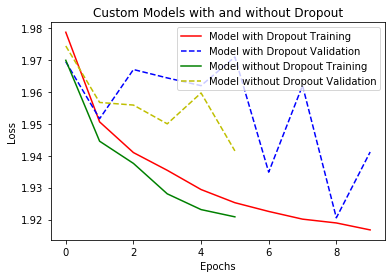

In [22]:
# Compare test accuracies
print("Test accuracy of model with BatchNorm: {}".format(dropout_model_accuracy))
print("Test accuracy of model without BatchNorm: {}".format(no_dropout_model_accuracy))

fig = plt.figure()
axes = plt.subplot(111)
axes.plot(dropout_model_metrics["losses_epoch_train"],color="r",linestyle="-" ,label='Model with Dropout Training')
axes.plot(dropout_model_metrics["losses_epoch_val"],color="b",linestyle="--" ,label='Model with Dropout Validation')
axes.plot(no_dropout_model_metrics["losses_epoch_train"],color="g",linestyle="-" ,label='Model without Dropout Training')
axes.plot(no_dropout_model_metrics["losses_epoch_val"],color="y",linestyle="--" ,label='Model without Dropout Validation')
axes.set_xlabel("Epochs")
axes.set_ylabel("Loss")
axes.legend()
axes.set_title("Custom Models with and without Dropout")
plt.show()

Model without dropout give better training loss but in validation with dropout is better. Therefore for better generalization we should include dropout layers.

### Optimizer Comparison

**Optimize two identical models one with SGD+Momentum and one with Adam**


In [23]:
model = YourModel()
# Model trained with SGD+Momentum
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate,momentum=0.8,weight_decay=1e-2)
criteria = nn.CrossEntropyLoss()

sgd_model_metrics = train(model,criteria,optimizer)
sgd_model_accuracy = test(model)
print("Model optimized with SGD+Momentum finished training")
model = YourModel()
# Model trained with Adam
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate,weight_decay=1e-2)
criteria = nn.CrossEntropyLoss()

adam_model_metrics = train(model,criteria,optimizer)
adam_model_accuracy = test(model)
print("Model optimized with Adam finished training")

Iteration [1 /1410] Training Loss: 2.085 Training Accuracy: 9.375
Iteration [101 /1410] Training Loss: 2.110 Training Accuracy: 9.375
Iteration [201 /1410] Training Loss: 1.961 Training Accuracy: 28.125
Iteration [301 /1410] Training Loss: 2.018 Training Accuracy: 18.750
Iteration [401 /1410] Training Loss: 2.057 Training Accuracy: 21.875
Iteration [501 /1410] Training Loss: 2.025 Training Accuracy: 25.000
Iteration [601 /1410] Training Loss: 1.956 Training Accuracy: 25.000
Iteration [701 /1410] Training Loss: 2.060 Training Accuracy: 15.625
Iteration [801 /1410] Training Loss: 1.985 Training Accuracy: 31.250
Iteration [901 /1410] Training Loss: 1.997 Training Accuracy: 25.000
Iteration [1001 /1410] Training Loss: 2.050 Training Accuracy: 18.750
Iteration [1101 /1410] Training Loss: 1.971 Training Accuracy: 28.125
Iteration [1201 /1410] Training Loss: 1.934 Training Accuracy: 31.250
Iteration [1301 /1410] Training Loss: 2.010 Training Accuracy: 25.000
Iteration [1401 /1410] Training Lo

Iteration [1 /1410] Training Loss: 1.994 Training Accuracy: 28.125
Iteration [101 /1410] Training Loss: 1.993 Training Accuracy: 28.125
Iteration [201 /1410] Training Loss: 2.024 Training Accuracy: 25.000
Iteration [301 /1410] Training Loss: 1.993 Training Accuracy: 28.125
Iteration [401 /1410] Training Loss: 1.987 Training Accuracy: 28.125
Iteration [501 /1410] Training Loss: 1.974 Training Accuracy: 31.250
Iteration [601 /1410] Training Loss: 2.149 Training Accuracy: 12.500
Iteration [701 /1410] Training Loss: 2.055 Training Accuracy: 21.875
Iteration [801 /1410] Training Loss: 2.087 Training Accuracy: 18.750
Iteration [901 /1410] Training Loss: 2.024 Training Accuracy: 25.000
Iteration [1001 /1410] Training Loss: 1.993 Training Accuracy: 28.125
Iteration [1101 /1410] Training Loss: 2.087 Training Accuracy: 18.750
Iteration [1201 /1410] Training Loss: 1.930 Training Accuracy: 34.375
Iteration [1301 /1410] Training Loss: 2.060 Training Accuracy: 21.875
Iteration [1401 /1410] Training 

**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies**

Test accuracy of model with BatchNorm: 32.2
Test accuracy of model without BatchNorm: 32.64


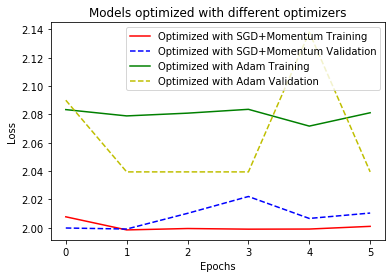

In [24]:
# Compare test accuracies
print("Test accuracy of model with BatchNorm: {}".format(dropout_model_accuracy))
print("Test accuracy of model without BatchNorm: {}".format(no_dropout_model_accuracy))

fig = plt.figure()
axes = plt.subplot(111)
axes.plot(sgd_model_metrics["losses_epoch_train"],color="r",linestyle="-" ,label='Optimized with SGD+Momentum Training')
axes.plot(sgd_model_metrics["losses_epoch_val"],color="b",linestyle="--" ,label='Optimized with SGD+Momentum Validation')
axes.plot(adam_model_metrics["losses_epoch_train"],color="g",linestyle="-" ,label='Optimized with Adam Training')
axes.plot(adam_model_metrics["losses_epoch_val"],color="y",linestyle="--" ,label='Optimized with Adam Validation')
axes.set_xlabel("Epochs")
axes.set_ylabel("Loss")
axes.legend()
axes.set_title("Models optimized with different optimizers")
plt.show()

From the results SGD+Momentum gave better results but I believe there is an error because in general Adam optimizers perform better training but due to model or the dataset SGD performed better than Adam.

This problem can be due to the my model


#### After you have completed the training, save your best model using the following command
#### Upload your best model to Google Drive and copy your link here: *https://drive.google.com/file/d/1IE7gGRyoPV7Fco4MlBDFw94Ln8kIa9F_/view?usp=sharing*

In [25]:
# Now we chose the best model which is DenseNet121
# Final training with more epochs will be made and result will be uploaded to Google Drive

In [26]:
# My best model is the DenseNet121 therefore i will use the densenet121 as best model
model = densenet
student_id = 504191504
torch.save(model.state_dict(), '{}.pth'.format(student_id))